### Import all necessary packages

In [73]:
# import numpy
import numpy as np
# import pandas
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
%matplotlib inline
# import scikit image tools for blob detection
from skimage import feature
# import scikit image tool for contour detection and polygon approximation
from skimage import measure
# import drawing tools for the polygon approximation of the area inside the spheroid
from skimage.draw import polygon, circle, circle_perimeter
# import openCV which is a feature detection and drawing package
import cv2
# import package that has operating system functions
import os

### Define relevant functions

In [80]:
#
#
#
def findBlobs(img, sigMin, sigMax, method, TH, OL, rF, subFrF, showBlobs):
    # function docstring
    """
    get blob coordinates and sub frames from source image by searching a 3D space of the image where the third coorindate is sigma values (plus image x and y [2D]).
    sigMin and sigMax define the sigma range for the smoothing applied to image for blob detection which is the third coordinate of the image cube.
    method: 0 -> determinant of Hessian, 1 -> Laplacian of Gaussian (recommended), 2 -> difference of Gaussian
    (see http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py)
    TH is the threshold for for the blob detection algorithm
    OL (overlap) is the minimal allowed distance between two blobs that the algorithm finds 
    rF proportionality factor for blob radius and sigma from blob detection
    subFrF proportionality factor for subFrame size (based on sigma(blob) as well)
    returns: subframes, x, y (blob coordinates in frame), rB (blob feature radius), xBsub, yBsub (blob coordinates in subframe coordinate system)
    use like so:
    subFr, xB, yB, rB, xBsub, yBsub = findBlobs(img, sigMin=10, sigMax=40, method=1, TH=0.01, OL=1, rF=1.4, subFrF=3.2, showBlobs=1)
    """
    sigNum = int((sigMax-sigMin)/5)
    sigRat = 1.6
    
    # find blobs hits and increase threshold if there are too many hits (-> currently more than 5)
    nrBlobs = 10
    while nrBlobs > 5:
        if method == 0: # determinant of Hessian method
            blobs = feature.blob_doh(img, min_sigma=sigMin, max_sigma=sigMax, \
                                     num_sigma=sigNum, threshold=TH, overlap=OL, log_scale=False)
        elif method == 1: # Laplacian of Gaussian method
            blobs = feature.blob_log(img, min_sigma=sigMin,max_sigma=sigMax, \
                                     num_sigma=sigNum, threshold=TH, overlap=OL, log_scale=False)
        elif method == 2: # Difference of Gaussian method
            blobs = feature.blob_dog(img, min_sigma=sigMin, max_sigma=sigMax, \
                                     sigma_ratio=sigRat, threshold=TH, overlap=OL)
        nrBlobs = len(blobs)
        TH = TH+0.01
    
    subFr = [] # subFrames
    xB = [] # x coordinates of blobs
    yB = [] # y coordinates of blobs
    rB = [] # radius information of blobs
    sB = [] # sigma information of blobs
    xStart = [] # subframes x axis start value
    yStart = [] # subframes y axis start value
    xStop = [] # subframes x axis stop value
    yStop = [] # subframes y axis stop value
    subFrSz = [] # subFrame sizes
    xBsub = [] # x coordinate of blob in subFrame coordinate system
    yBsub = [] # y coordinate of blob in subFrame coordinate system
    
    E=20 # minimal distance to edge of image for blob detection to produce a find/output
    thick = 2 # thickness of boxes and circles drawn around blobs
    if showBlobs == 1: imgOut = img.copy()
    
    for k,blob in enumerate(blobs):
        # if sigma is not sigmaMin or blob coordinates are too close to edge of the image, then use this hit/result
        if (blob[2]!=sigMin and blob[0]>E and blob[1]>E and blob[0]<(img.shape[0]-E) and blob[1]<(img.shape[1]-E)): 
            xB.append(int(blob[1])) # get x coordinate from hit
            yB.append(int(blob[0])) # get y coordinate from hit
            sB.append(blob[2]) # get list of sigmas from hits
            rB.append(int(blob[2]*rF)) # get radius for blob based on sigma(blob) with proportionality factor rF
            subFrSz.append(int(blob[2]*subFrF)) # get subFrame size from sigma(blob)
            minFrSz = 70 # define minimal frame size
            if subFrSz[-1] < minFrSz: subFrSz[-1] = minFrSz 
            # define boarders of subframes
            xStart.append(xB[-1]-subFrSz[-1])
            xStop.append(xB[-1]+subFrSz[-1])
            yStart.append(yB[-1]-subFrSz[-1])
            yStop.append(yB[-1]+subFrSz[-1])
            if showBlobs == 1:
                # draw center
                cv2.rectangle(imgOut, (xB[-1]-thick, yB[-1]-thick), (xB[-1]+thick, yB[-1]+thick), (255, 0, 0), -1)
                # draw outline of subframe
                cv2.rectangle(imgOut, (xB[-1]-subFrSz[-1], yB[-1]-subFrSz[-1]), \
                              (xB[-1]+subFrSz[-1], yB[-1]+subFrSz[-1]), (255, 0, 0), thick)
                # draw circle with radius proportional to sigma(blob)
                # cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
                cv2.circle(imgOut, (xB[-1], yB[-1]), rB[-1], (255, 0, 0), thick)
            # get rid of negative values (replace with zeros)
            # negative values are a result of blobs close to the image boundary
            if xStart[-1] < 0: xStart[-1] = 0
            if yStart[-1] < 0: yStart[-1] = 0
            if xStop[-1] > img.shape[1]: xStop[-1] = img.shape[1]
            if yStop[-1] > img.shape[0]: yStop[-1] = img.shape[0]
            # cut subframes from input image
            subFr.append(img[yStart[-1]:yStop[-1]+1, xStart[-1]:xStop[-1]+1])
            # define blob center coordinates in subframe coordinate system
            xBsub.append(xB[-1] - xStart[-1])
            yBsub.append(yB[-1] - yStart[-1])
            
    # show raw data images above blobs found in respective image
    if showBlobs == 1:
        print('number of potential blobs found: ' + str(nrBlobs))
        figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(imgOut)
        plt.show()

    return(subFr, xB, yB, rB, xBsub, yBsub, sB)

#
#
#
def getContour(img, HT, xBsub, yBsub, sB):
    # function docstring
    """
    use contour detection (measure from the skimage toolkit) to find contours at a constant value (height [HT]).
    the height can be chosen via the HT value (positive values) or the mean of the image (img) intensity can be used (HT=-1)
    xBsub and yBsub are the blob center coordinates in the image (img). [use getBlobs function].
    of all found contours the one with the smallest absolute mean distance to the blob center will be chosen
    and subdivided into a polygon using 2nd degree B-Splines which will be approximated with Douglas-Peucker algorithm.
    the function returns the coordinates of this approximated polygon describing the contour and the original contour coordinates.
    use like so:
    apprPoly, contMinDistAbs = getContour(img, HT=-1, xBsub, yBsub)
    """
    if HT == -1: # check contours at several intensities before determining right one
        imgContours = [] # initialize
        # define array of intensities (95% to 105% of mean intensity in 5% steps)
        intStep = 0.05
        HTs = np.mean(img)*np.arange(0.95, 1.05+intStep, intStep)
        
        for i in range(len(HTs)):
            HTtemp = HTs[i] # go through array of intensities
            # add new contours to the list of contour arrays called "imgContours"
            imgContours = imgContours + measure.find_contours(img, HTtemp, fully_connected='high', positive_orientation='high')
    else: # only check contours at the user input intensity
        imgContours = measure.find_contours(img, HT, fully_connected='high', positive_orientation='high')
    
    # go through all contours found that have a length above a certain thershold
    imgContHT = [] # all contours (specifically their coordinates)
    contLen = [] # contour lengths
    contDist = [] # mean distance (x and y) to the blob center of all contours
    contDistAbs = [] # sum of absolute mean x and y distances of countour with respect to blob center
    # go through all contours found that have a length within a certain thershold
    # and sort out contours that are not closed loops
    for n, contour in enumerate(imgContours):
        if (contour.shape[0]>sB*20 and contour.shape[0]<sB*40 and all(contour[0]==contour[-1])):
            # add contour to new shorter list
            imgContHT.append(contour)
            # log lenghts of contour
            contLen.append(contour.shape[0])
            # log average distance of contour points to blob center
            contDist.append([np.mean(contour[:, 1])-xBsub, np.mean(contour[:, 0])-yBsub])
            # use the absolute values of those two distances as a metric for choosing the contour of interest (COI)
            contDistAbs.append(np.abs(contDist[-1][0])+np.abs(contDist[-1][1]))
    
    print('number of contours found: ' + str(len(imgContHT)))
    
    # choose the contour with the center of mass closest to the detected blob center
    if len(imgContHT)!=0: # check if there are any appropriate length contours
        if np.min(contDistAbs) < 50:
            # get the contour with the smallest absolute mean distance to the blob center
            contMinDistAbs = imgContHT[contDistAbs.index(np.min(contDistAbs))]
            # subdivide contour of interest into polygon using 2nd degree B-Splines
            contPoly = measure.subdivide_polygon(contMinDistAbs, degree=2, preserve_ends=True)
            # approximate subdivided polygon with Douglas-Peucker algorithm
            apprPoly = measure.approximate_polygon(contPoly, tolerance=0.1)
            print('length of best contour: ' + str(contMinDistAbs.shape[0]))
            print('abs distance(center of mass, blob center) (x+y): ' + str(round(np.min(contDistAbs),1)))
            # return this approximated polygon and the contour with the minimal absolute distance to the blob center
            return(apprPoly, contMinDistAbs)
        else:
            print('none of the found contours has small enough absolute center of mass distance to blob center.')
            return(np.array([0,0]), np.array([0,0]))
    else:
        print('none of the found contours has length within the thresholds and is a closed contour.')
        return(np.array([0,0]), np.array([0,0]))
#
#
#
def getFLinPoly(img, apprPoly, xBsub, yBsub, rB):
    # function docstring
    """
    this function integrates the intensity of pixels within a polygon (apprPoly) in an image (img).
    and in a circle defined by xBsub, yBsub (coordinates) and rB (radius) [find this with getBlobs]
    return: mean, standard deviation and number of pixles within the polygon and circle
    use like so:
    FLcontMean, FLcontSD, FLcontPixels, FLcircMean, FLcircSD, FLcircPixels = getFLinPoly(img, poly, xBsub, yBsub, rB)
    """
    # get average flourescence from pixels within contour
    rrP, ccP = polygon(apprPoly[:,0], apprPoly[:,1], shape=img.shape) # get coordinates inside polygon
    FLcontMean = np.mean(img[rrP,ccP]) # calculate mean value
    FLcontSD = np.std(img[rrP,ccP]) # calculate standard deviation
    FLcontPixels = img[rrP,ccP].size # get number of pixels inside polygon

    # compare this to mean intensity in circle from blob find
    rrC, ccC = circle(xBsub, yBsub, rB, shape=img.shape) # get coordinates inside circle
    rrCper, ccCper = circle_perimeter(xBsub, yBsub, rB, method='bresenham', shape=img.shape) # get perimeter coordinates (for image)
    FLcircMean = np.mean(img[rrC,ccC]) # calculate mean value
    FLcircSD = np.std(img[rrC,ccC]) # calculate standard deviation
    FLcircPixels = img[rrC,ccC].size # get number of pixels inside circle
    
    return(FLcontMean, FLcontSD, FLcontPixels, FLcircMean, FLcircSD, FLcircPixels)

#
#
#
def saveContPlot(savePath, img, apprPoly, contFind, xBsub, yBsub, rB, showFig, saveFig):
    # function docstring
    """
    plot the image with what is hopefully the contour we want to use to define flourescence area.
    use getContour to generate the approximated poloygon (apprPoly) and contour (contFind) inputs.
    pass path to save figure at via the savePath variable.
    xBsub and yBsub are the blob center coordinates in the subFrame, rB is associated with the blob size.
    show = 1(/0) does (/not) show the saved image in the jupyterlab notebook (atm always shows).
    use like so:
    finalPlot = saveContPlot(path, img, polygon, contour, xBsub, yBsub, rB, showFig=0, saveFig=1)
    """
    figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    # draw circle with radius proportional to sigma(blob)
    rrCper, ccCper = circle_perimeter(xBsub, yBsub, rB, method='bresenham', shape=img.shape) # get perimeter coordinates (for image)
    plt.plot(rrCper, ccCper, '.', color='#0000CD', markersize=2) # blue circle
    # draw center
    plt.plot(xBsub, yBsub, '+', color='#0000CD', markersize=8) # blue plus sign
    # plot approximated contour of interest
    plt.plot(apprPoly[:, 1], apprPoly[:, 0], color='#FFD700', linestyle='-', linewidth=2) # solid yellow
    # plot contour of interest
    plt.plot(contFind[:, 1], contFind[:, 0], color='#EA0E33', linestyle=':', linewidth=1) # dotted red
    # save this plot generated with matplotlib
    if saveFig == 1: plt.savefig(savePath) 
    # show plot 
    if showFig == 1: plt.show()
    # close figure
    elif showFig == 0: plt.close()

#
#
#
def findAllSubStrInStr(strIN, sub, overlap):
    # function docstring
    """this function finds all instances of <sub> in <strIN> and returns a list of indices of where the matches start in <strIN>
    to find overlapping matches, which is slower, set overlap to 1, otherwise 0.
    use like so:
    listIND = list(findAllSubStrInStr(textStr, searchStr, overlap))
    """
    start = 0
    while True:
        start = strIN.find(sub, start)
        if start == -1: return
        yield start
        if overlap == 0: # non-overlapping matches, faster:
            start += len(sub) 
        elif overlap == 1: # find overlapping matches, slower:
            start += 1

### Read all files/ images in folder

In [81]:
currUser = os.getlogin() # get current user name [alternatively use getpass.getuser()]

# read all files in folder defined in next line
# !!!!! --- DEFINE FOLDER NAME WITH DATA IMAGES RIGHT HERE --- !!!!!
fileFolder = 'C:\\Users\\' + currUser + '\\OneDrive\\python jupyterlab\\fluorescence integration Karen\\data'

# get all files from the above folder
allFiles = [f for f in os.listdir(fileFolder) if os.path.isfile(os.path.join(fileFolder, f))]
# get full path for all files
allPaths = [fileFolder + '\\' + allFiles[p] for p in range(len(allFiles))]
# read all files/ images
imgs = [cv2.imread(fileFolder + "\\" + allFiles[d], 0) for d in range(len(allPaths))]
# second argument -1, 0, 1 corresponds to:
# cv2.IMREAD_COLOR : Loads a color image. Any transparency of image will be neglected. It is the default flag.
# cv2.IMREAD_GRAYSCALE : Loads image in grayscale mode
# cv2.IMREAD_UNCHANGED : Loads image as such including alpha channel

# get indices of dot location for all file names such that we can save the blob images
# with the original file name plus an incremental number for each blob in the image
dotINDs = [list(findAllSubStrInStr(allFiles[m], '.', 0)) for m in range(len(allFiles))]

print("Number of files found: " + str(len(allPaths)))
print("List of all file/image paths:")
for s in range(len(allPaths)): print(allPaths[s])

Number of files found: 3
List of all file/image paths:
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\10uMRho 123  no inhibitor change back 012_RGB.tif
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\Rho5_cyst_t2picture004_RGB.tif
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\Rho5_cyst_t2picture_RGB.tif


### Find pixel to micrometer scale

full image size is:
(512, 512)
image with bar length equal to horizontal size is:
62
pixel per micrometer (1D):
0.62


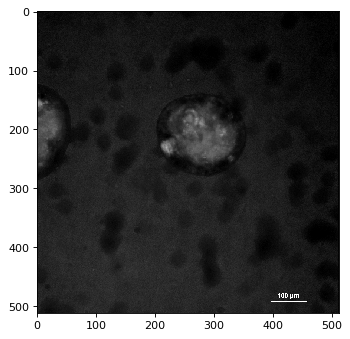

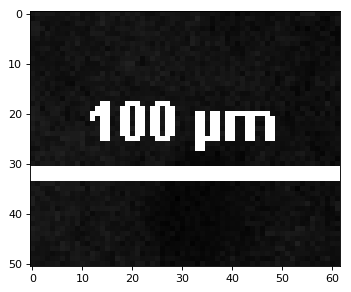

In [82]:
# this will use the first image in the folder and assume that the scale is equal for all of them
print('full image size is:')
print(imgs[0].shape)
figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(imgs[0], interpolation='nearest', cmap=plt.cm.gray)

# vary x axis start and stop values until the image on the bottom (2nd one)
# shows only the size bar (width) and no other (black) pixels on the side of the bar
yTestStart = 460
yTestStop = 510
xTestStart = 396 # <--- adjust
xTestStop = 457 # <--- adjust
testFrame = []

# cut subframe from input image
testFrame.append(imgs[0][yTestStart:yTestStop+1, xTestStart:xTestStop+1])
figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(testFrame[-1], interpolation='nearest', cmap=plt.cm.gray)

print('image with bar length equal to horizontal size is:')
print(testFrame[-1].shape[1])

mumBarLength = 100 # length of bar in micrometer
pPmum = testFrame[-1].shape[1]/mumBarLength # pixels per micrometer
print('pixel per micrometer (1D):')
print(pPmum)

### MAIN: Find all spheroids in all images, save found subframes with spheroid wall outline as .png and fluorescence information in CSV file


---------- new image ----------
10uMRho 123  no inhibitor change back 012_RGB
number of potential blobs found: 4


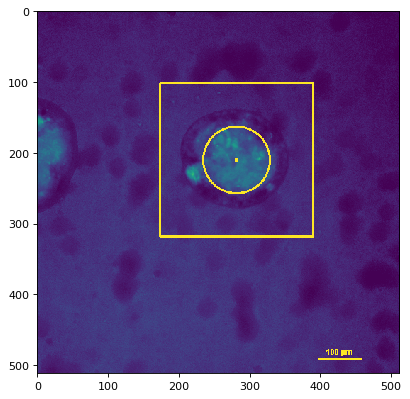

blob number: 0
number of contours found: 3
length of best contour: 719
abs distance(center of mass, blob center) (x+y): 6.2
sigma: 34.0
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\10uMRho 123  no inhibitor change back 012_RGB_blob0.png


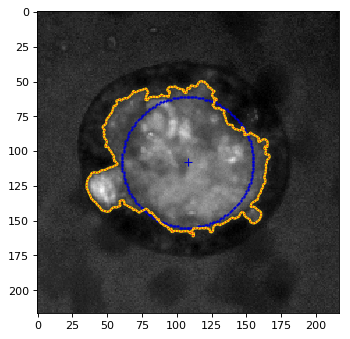



---------- new image ----------
Rho5_cyst_t2picture004_RGB
number of potential blobs found: 3


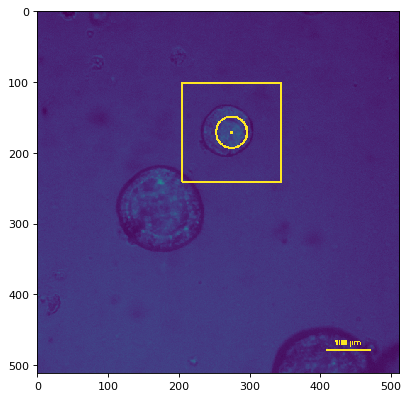

blob number: 0
number of contours found: 5
length of best contour: 431
abs distance(center of mass, blob center) (x+y): 7.3
sigma: 16.0
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\Rho5_cyst_t2picture004_RGB_blob0.png


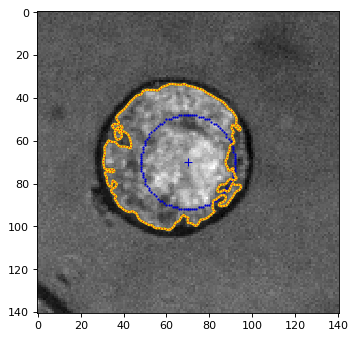



---------- new image ----------
Rho5_cyst_t2picture_RGB
number of potential blobs found: 3


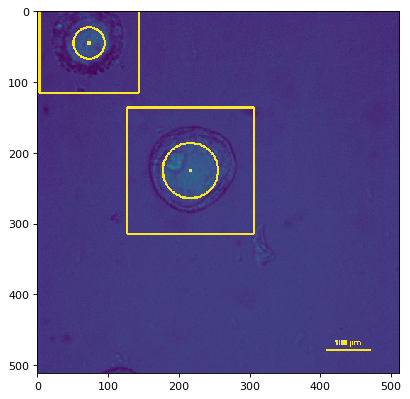

blob number: 0
number of contours found: 4
length of best contour: 1057
abs distance(center of mass, blob center) (x+y): 2.2
sigma: 28.0
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\Rho5_cyst_t2picture_RGB_blob0.png


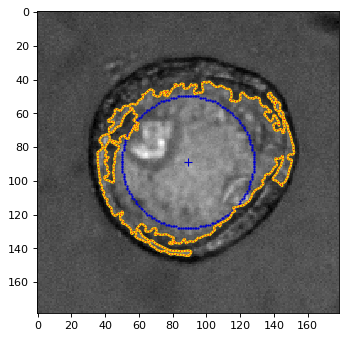


blob number: 1
number of contours found: 3
length of best contour: 371
abs distance(center of mass, blob center) (x+y): 8.3
sigma: 16.0
C:\Users\Hans\OneDrive\python jupyterlab\fluorescence integration Karen\data\Rho5_cyst_t2picture_RGB_blob1.png


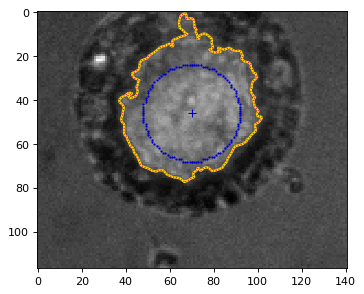

,File Name,File Path,Mean FL contour,SD FL contour,Pixels in contour,mum^2 in contour,Mean FL circle,SD FL circle,Pixels in circle,mum^2 in circle
0,10uMRho 123 no inhibitor change back 012_RGB_...,C:\Users\Hans\OneDrive\python jupyterlab\fluor...,0.002849,0.000904,9615,25013.007284,0.004216,0.001151,6917,17994.276795
1,Rho5_cyst_t2picture004_RGB_blob0.png,C:\Users\Hans\OneDrive\python jupyterlab\fluor...,0.005917,0.001277,3163,8228.407908,0.013490,0.002871,1513,3936.004162
2,Rho5_cyst_t2picture_RGB_blob0.png,C:\Users\Hans\OneDrive\python jupyterlab\fluor...,0.003276,0.000603,7571,19695.629553,0.005656,0.000830,4765,12395.941727
3,Rho5_cyst_t2picture_RGB_blob1.png,C:\Users\Hans\OneDrive\python jupyterlab\fluor...,0.007594,0.001367,3054,7944.849116,0.009988,0.004955,1513,3936.004162


In [83]:
debugging = 1 # show every individual blob found in all images (0=no, 1=yes)
saveResults = 0 # save -"-

pPmum2 = pPmum**2 # pixel per micrometer squared (see box above for pPmum value definition)

# intialize columns of CSV file to save
saveFileNames = []
savePaths = []
FLcontMeanPmum2 = [] # mean fluorescence per micrometer^2 inside contour
FLcontSDPmum2 = [] # standard deviation
FLcontP = [] # number of pixels inside contour
FLcontMum2 = [] # countour area in units of micrometer^2
# below are the same values with regard to the circle instead of the contour
FLcircMeanPmum2 = []
FLcircSDPmum2 = []
FLcircP = []
FLcircMum2 = []

# main loop
for n in range(len(allPaths)): # go through all files found in box above
    
    # show raw data images above blobs found in respective image
    if debugging == 1: 
        print()
        print('---------- new image ----------')
        print(allFiles[n][0:dotINDs[n][0]])
    # find blobs i.e. spheriods in the images and get their position and size
    radF = 1.4
    (subFr, xB, yB, rB, xBsub, yBsub, sB) = findBlobs(imgs[n], sigMin=10, sigMax=40, method=1, \
                                                  TH=0.03, OL=0.1, rF=radF, subFrF=3.2, showBlobs=debugging)
            
    for q in range(len(rB)): # go through all blobs/ subframes
        print('blob number: ' + str(q))
        # find the contour that goes along the inner spheroid wall
        # HT=-1: use mean of image as height to check for contours
        apprPoly, contFind = getContour(subFr[q], -1, xBsub[q], yBsub[q], sB[q])
        
        # if no fitting contour is found in getContour this function returns an array=[0,0]
        if apprPoly.shape[0]>2: # if that is the case, ignore this blob and move to next one
            # define a name for the new image to be saved
            # image will contain the found blob/ spheroid, the contour, its approximated polygon
            # and the circle (center and size determined by the blob detection) 
            saveFileNames.append(allFiles[n][0:dotINDs[n][0]] + '_blob' + str(q) + '.png') # file name
            savePaths.append(fileFolder + '\\' + saveFileNames[-1]) # file path
            if debugging == 1:
                print('sigma: ' + str(round(sB[q],1)))
                print(savePaths[-1])
                
            # get the flourescence intensity inside this contour and inside the (blob detected) circle
            FLcontMean, FLcontSD, FLcontPixels, FLcircMean, FLcircSD, FLcircPixels = getFLinPoly( \
                                                    subFr[q], apprPoly, xBsub[q], yBsub[q], rB[q])
            # normalize these numbers to the micrometer scale (bottom right of the original images has the 100µm bar)
            # normalize contour data
            FLcontMeanPmum2.append(FLcontMean/FLcontPixels*pPmum2)
            FLcontSDPmum2.append(FLcontSD/FLcontPixels*pPmum2)
            FLcontP.append(FLcontPixels)
            FLcontMum2.append(FLcontP[-1]/pPmum2)
            # normalize circle data
            FLcircMeanPmum2.append(FLcircMean/FLcircPixels*pPmum2)
            FLcircSDPmum2.append(FLcircSD/FLcircPixels*pPmum2)
            FLcircP.append(FLcircPixels)
            FLcircMum2.append(FLcircP[-1]/pPmum2)
        
            # create and save the image described above
            saveContPlot(savePaths[-1], subFr[q], apprPoly, contFind, xBsub[q], yBsub[q], rB[q], debugging, saveResults)
            print() # empty line
        
# start a pandas data frame for the CSV file containing fluorescence information
dfFL = pd.DataFrame(data=saveFileNames, columns=['File Name'])
# add these normalized numbers to a pandas dataframe containing information on all detected blobs
# i.e. filename (saved), blob number, center coordinates and radii, fluorescence in contour and circle,
# standard deviation, pixels, area (µm)
dfFL.insert(dfFL.shape[1], 'File Path', savePaths)
dfFL.insert(dfFL.shape[1], 'Mean FL contour', FLcontMeanPmum2)
dfFL.insert(dfFL.shape[1], 'SD FL contour', FLcontSDPmum2)
dfFL.insert(dfFL.shape[1], 'Pixels in contour', FLcontP)
dfFL.insert(dfFL.shape[1], 'mum^2 in contour', FLcontMum2)
dfFL.insert(dfFL.shape[1], 'Mean FL circle', FLcircMeanPmum2)
dfFL.insert(dfFL.shape[1], 'SD FL circle', FLcircSDPmum2)
dfFL.insert(dfFL.shape[1], 'Pixels in circle', FLcircP)
dfFL.insert(dfFL.shape[1], 'mum^2 in circle', FLcircMum2)

if saveResults == 1: # save the pandas dataframe filled in the above loop with spheroid info in a CSV file
    CSVsavePath = fileFolder + "\\FLinfo.dat" # define new file path
    with open(CSVsavePath, 'w', newline='') as fileSave: # save data to file
        dfFL.to_csv(fileSave)

# statistics on column
# get mean and standard deviation for fluorescence data across blobs?

# show data frame containing fluorescence data on all found blobs
dfFL # this table will get saved under the name "FLinfo.dat" in the folder defined as <fileFolder>